In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config_df = pd.read_csv("sbert.csv")
epoch_df = pd.read_csv("sbert_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,pooling_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,weight_decay,...,peak_memory,reg_train_loss,reg_train_rmse,reg_train_pearson,reg_valid_loss,reg_valid_rmse,reg_valid_pearson,reg_test_loss,reg_test_rmse,reg_test_pearson
0,0,model_test,sentence-transformers/distiluse-base-multiling...,mean,16,13,0.00002,0.1,0.1,0.01,...,7028.749512,0.001077,0.032812,0.991458,0.010192,0.100956,0.926784,0.009593,0.097943,0.928017
1,1,model_test,sentence-transformers/distiluse-base-multiling...,cls,16,7,0.00002,0.1,0.1,0.01,...,7543.395996,0.001592,0.039894,0.987346,0.010907,0.104435,0.920868,0.009068,0.095228,0.931893
2,2,model_test,sentence-transformers/distiluse-base-multiling...,max,16,14,0.00002,0.1,0.1,0.01,...,8042.776855,0.001350,0.036746,0.989275,0.010676,0.103323,0.923014,0.009512,0.097530,0.928479
3,3,model_test,sentence-transformers/distiluse-base-multiling...,attention,16,14,0.00002,0.1,0.1,0.01,...,8575.966309,0.001131,0.033628,0.991025,0.009650,0.098234,0.929809,0.009620,0.098080,0.927746


# Training Plot

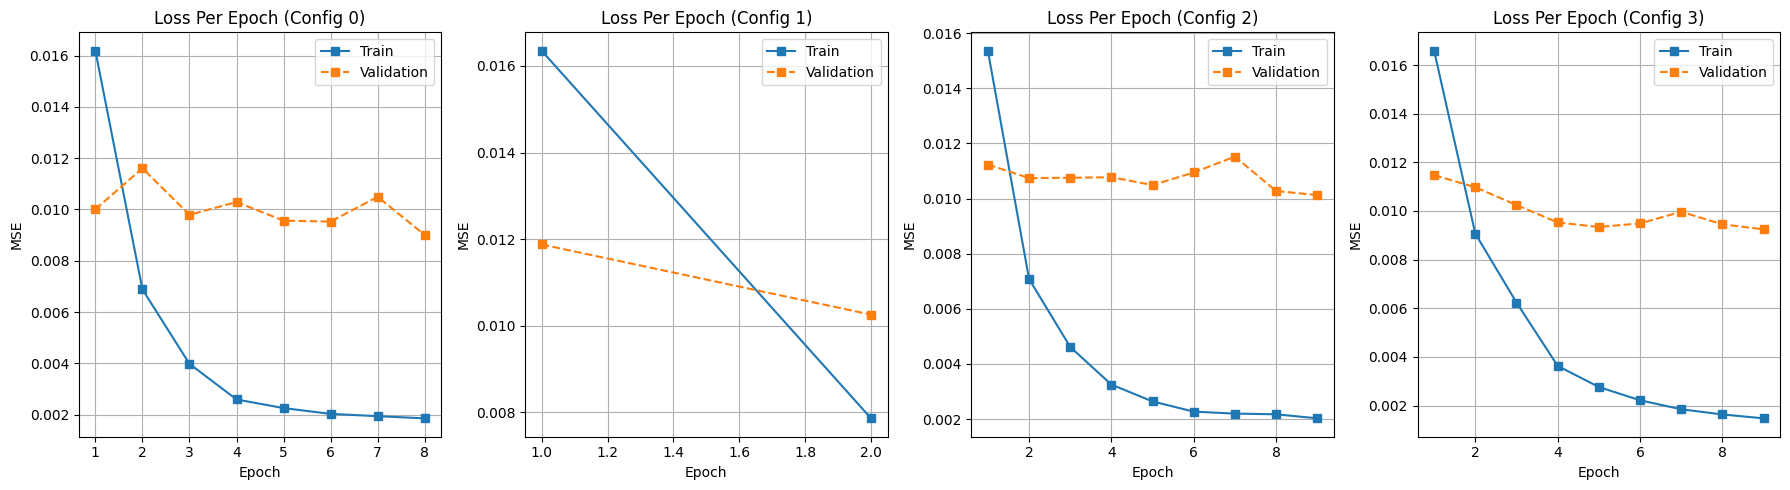

In [3]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5)) 

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [4]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import AutoTokenizer
from main_similarity import SiameseModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")

def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict(df_test, config_id, model):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    
    checkpoint = torch.load(f"../../../models/pooling/spesific/sbert_{config_id}.pt", map_location='cuda', weights_only=True)
    reg_model = joblib.load(f"../../../models/pooling/spesific/reg_{config_id}.pkl")
    model.load_state_dict(checkpoint)
    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [ ]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
for row in config_df.itertuples():
    model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2", pooling_type=row.pooling_type).to('cuda')
    all_predictions, all_targets = predict(df_test, row.config_id, model)

    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "sbert_prediction.csv"))


>> Mean Pooling
RMSE: 0.0996, Pearson: 0.9285

>> CLS Pooling
RMSE: 0.1000, Pearson: 0.9257

>> Max Pooling
RMSE: 0.1011, Pearson: 0.9233

>> Attention Pooling
RMSE: 0.0965, Pearson: 0.9314


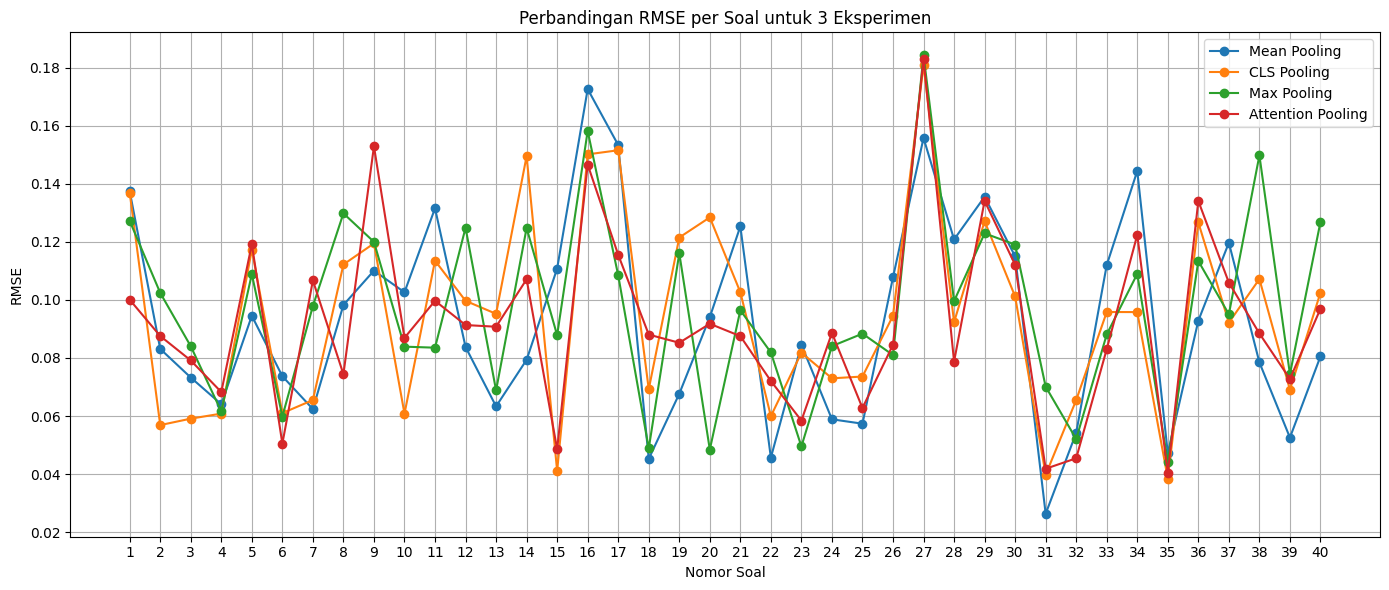

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("sbert")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_0": "Mean Pooling",
    "predicted_score_1": "CLS Pooling",
    "predicted_score_2": "Max Pooling",
    "predicted_score_3": "Attention Pooling",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [7]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])


num_models = len(model_data)

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")


Attention Pooling:
  Outlier (Fixed ±0.2): 10
  Outlier (Fixed ±0.1): 64

CLS Pooling:
  Outlier (Fixed ±0.2): 16
  Outlier (Fixed ±0.1): 62

Max Pooling:
  Outlier (Fixed ±0.2): 12
  Outlier (Fixed ±0.1): 63

Mean Pooling:
  Outlier (Fixed ±0.2): 16
  Outlier (Fixed ±0.1): 50

